# U-Net Convolutional Neural Network (CNN)
## Segmentation of images of colloidal particles
#### Ross Carmichael
#### 12/10/21

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

from glob import glob
import os
import numpy as np
import cv2

In [28]:
BATCH_SIZE = 89
BUFFER_SIZE = 1000

In [50]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "training_images/*.png")))
    masks = sorted(glob(os.path.join(path, "training_masks/*.png")))

    return images, masks

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = image.astype(np.float32)

    return image

def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)
    
    return mask

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([128, 128, 3])
    masks.set_shape([128, 128, 1])

    return images, masks

def tf_dataset(x, y, batch=BATCH_SIZE, buffer_size=BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size, seed=2)
    dataset = dataset.map(preprocess)
#     dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    
    return dataset

def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)
    
    return train_ds, val_ds, test_ds

In [54]:
path = "./training/"

# File paths
images, masks = load_data(path)
print(f"Images: {len(images)} - Masks: {len(masks)}")

x = read_image(images[0])
y = read_mask(masks[0])
print(x.shape, y.shape)

dataset = tf_dataset(images, masks)

assert len(images) == len(masks), "Number of images and segmentation masks is not equal."
ds_size = len(images)

_train_ds, _val_ds, _test_ds = get_dataset_partitions_tf(dataset, ds_size)

# Dataset containing subsets for train, val and test
dataset = {
           "train" :      _train_ds, 
           "validation" : _val_ds,
           "test" :       _test_ds
          }

train_batches = dataset["train"].batch(BATCH_SIZE)
test_batches = dataset["test"].batch(BATCH_SIZE)

Images: 2448 - Masks: 2448
(128, 128, 3) (128, 128, 1)


In [55]:
SIZE_TRAIN = len(dataset["train"])
SIZE_VALIDATION = len(dataset["validation"])
SIZE_TEST = len(dataset["test"])
STEPS_PER_EPOCH = SIZE_TRAIN // BATCH_SIZE

print(f"Batch size:       {BATCH_SIZE}")
print(f"Buffer size:      {BUFFER_SIZE}")
print(f"Training batches: {len(train_batches)}")
print(f"Test batches:     {len(test_batches)}")
print(f"Steps per epoch:  {STEPS_PER_EPOCH}\n")

print(f"Train size:       {SIZE_TRAIN}")
print(f"Validation size:  {SIZE_VALIDATION}")
print(f"Test size:        {SIZE_TEST}")

Batch size:       89
Buffer size:      1000
Training batches: 22
Test batches:     3
Steps per epoch:  22

Train size:       1958
Validation size:  244
Test size:        244


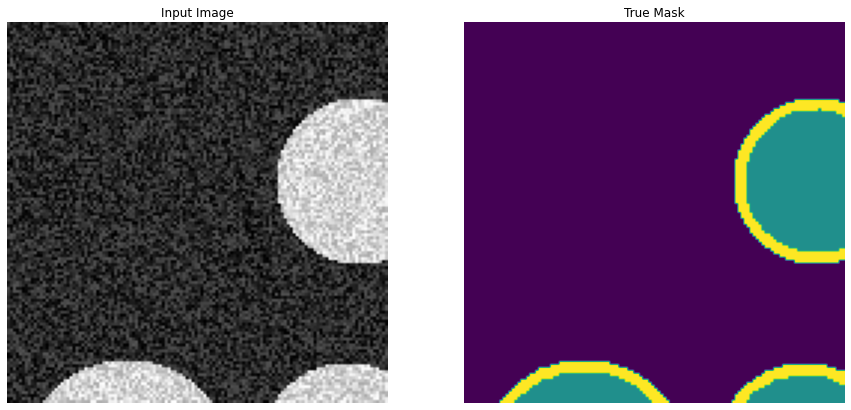

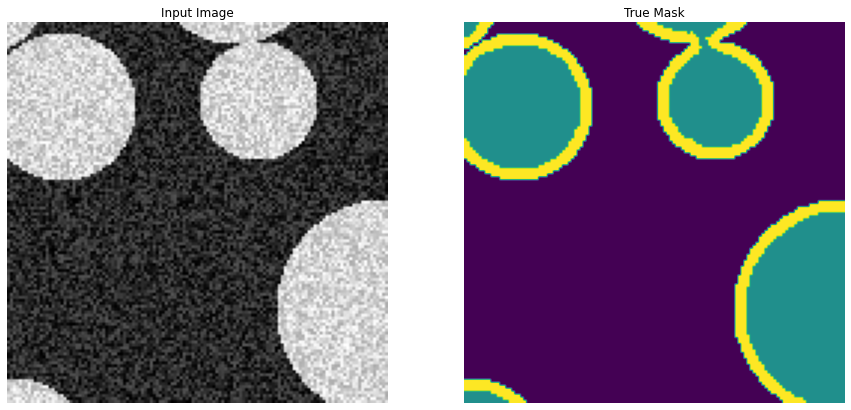

In [57]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in train_batches.take(2):
    sample_image, sample_mask = image[0], mask[0]
    display([sample_image, sample_mask])

In [58]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [59]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [60]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [61]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


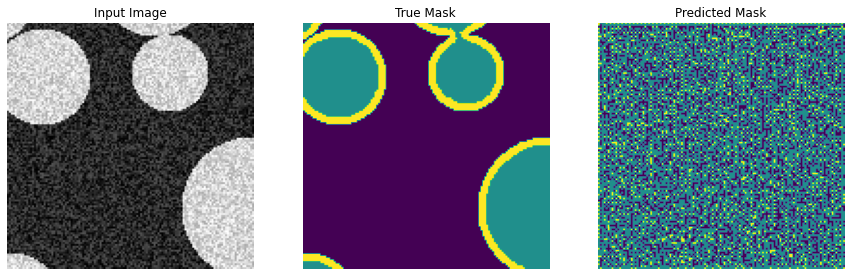

In [63]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [64]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

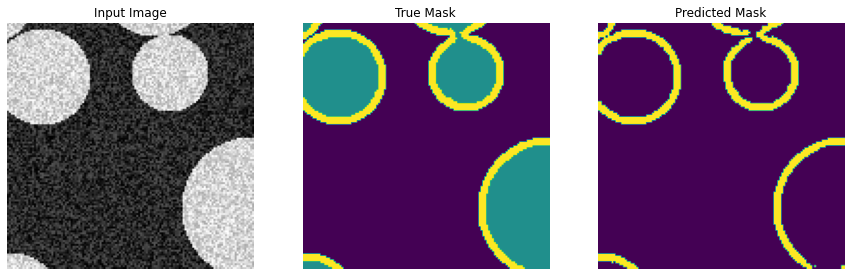


Sample Prediction after epoch 20


Epoch 00020: saving model to checkpoint/cp.ckpt


In [84]:
import os

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = SIZE_TEST//BATCH_SIZE//VAL_SUBSPLITS

checkpoint_path = "checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches, # should be validation data
                          callbacks=[DisplayCallback(), cp_callback])

In [85]:
!mkdir -p saved_model
model.save("saved_model/model_1.1_20_epochs")

/Users/ross/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_model/model_1.1_20_epochs/assets


In [86]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy'])


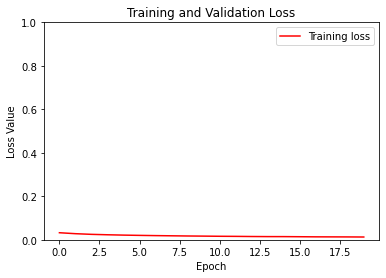

In [87]:
loss = model_history.history['loss']
#val_loss = model_history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
#plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

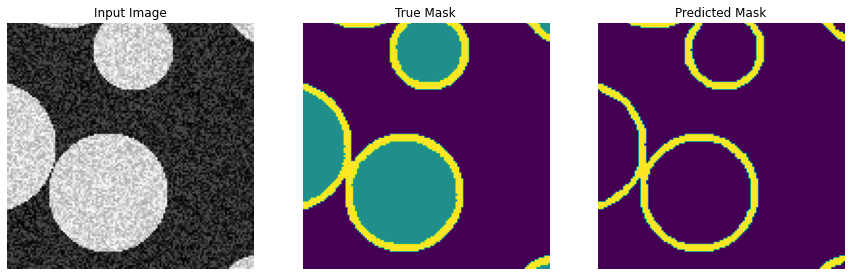

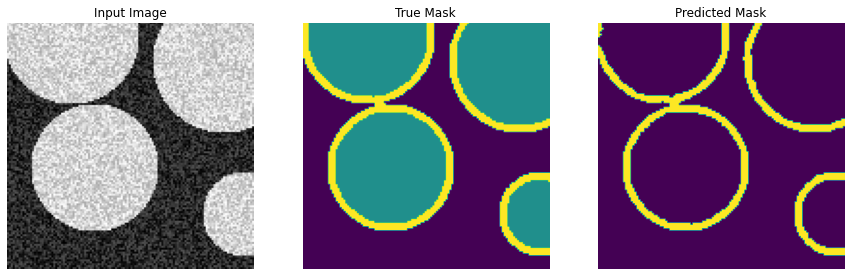

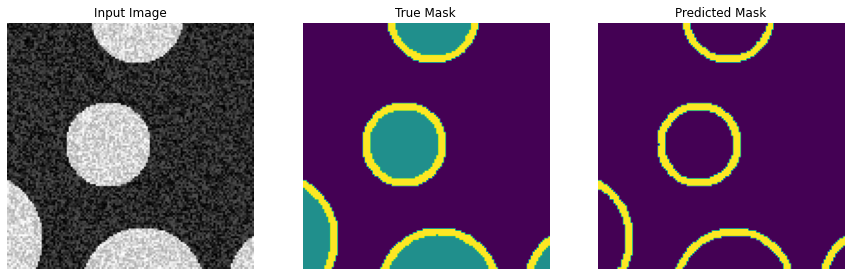

In [88]:
show_predictions(test_batches, 6)

In [ ]:
print(model.)